In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

In [27]:
def initialisation(dimensions):

    C = len(dimensions) 
    
    parametres = {}
    for c in range(1, C):
        parametres['W' +str(c)] = np.random.randn(dimensions[c], dimensions[c-1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)
        
    return parametres

In [3]:
# test de l'initialisation
param = initialisation([2, 32, 32,1])

for key, val in param.items():
    print(key, val.shape)


W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (1, 32)
b3 (1, 1)


In [28]:
def activation(Z, activation_type="sigmoid"):
    if activation_type == "sigmoid":
        return 1 / (1 + np.exp(-Z))
    elif activation_type == "relu":
        return np.maximum(0, Z)
    elif activation_type == "tanh":
        return np.tanh(Z)
    elif activation_type == "leaky_relu":
        return np.maximum(0.01 * Z, Z)
    # Ajoutez d'autres fonctions au besoin
    
def activation_derivative(A, Z, activation_type="sigmoid"):
    if activation_type == "sigmoid":
        return A * (1 - A)
    elif activation_type == "relu":
        return (Z > 0).astype(float)
    elif activation_type == "tanh":
        return 1 - np.power(A, 2)
    elif activation_type == "leaky_relu":
        dA = np.ones_like(Z)
        dA[Z < 0] = 0.01
        return dA
    # Ajoutez d'autres dérivées au besoin

def forward_propagation(X, parametres, activation_types=None):

    C = len(parametres) // 2 #comme W et b présent, alors on divise par 2
    activations = {'A0' : X}
    Z_values = {}
    
        # Si aucune liste d'activations n'est fournie, utiliser sigmoid partout
    if activation_types is None:
        activation_types = ["sigmoid"] * C
    
    for c in range(1, C +1): 
        Z = parametres['W'+str(c)].dot(activations['A' +str(c-1)]) + parametres['b'+str(c)]
        Z_values['Z'+str(c)] = Z
        
        # Utiliser la fonction d'activation spécifiée pour cette couche
        act_type = activation_types[c-1]
        activations['A'+str(c)] = activation(Z, act_type)

        
    return activations, Z_values

In [5]:
#test de la forward propoagation
params = initialisation([2, 32, 32,1])
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))
activations = forward_propagation(X, param)
for key, val in activations.items():
    print(key, val.shape)


A0 (2, 1000)
A1 (32, 1000)
A2 (32, 1000)
A3 (1, 1000)


In [29]:
def back_propagation(y, parametres, activations, Z_values, activation_types=None):

    m = y.shape[1]
    C = len(parametres) // 2 
    
    # Si aucune liste d'activations n'est fournie, utiliser sigmoid partout
    if activation_types is None:
        activation_types = ["sigmoid"] * C
    
    # Pour la dernière couche (toujours sigmoid pour la classification binaire)
    dZ = activations['A' + str(C)] - y
    gradients = {}
    
    for c in reversed(range(1, C+1)):
        gradients['dW'+ str(c)] = 1/m * np.dot(dZ, activations['A' + str(c -1)].T)
        gradients['db'+ str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        
        if c > 1:
            # Calcul de dZ pour la couche précédente
            dA = np.dot(parametres['W'+ str(c)].T, dZ)
            Z_prev = Z_values['Z' + str(c-1)]
            A_prev = activations['A' + str(c-1)]
            act_type = activation_types[c-2]  # -2 car index commence à 0 et on a déjà décrémenté c
            
            dZ = dA * activation_derivative(A_prev, Z_prev, act_type)
    
    return gradients

In [8]:
grad = back_propagation(y, params, activations)

for key, val in grad.items():
    print(key, val.shape)


dW3 (1, 32)
db3 (1, 1)
dW2 (32, 32)
db2 (32, 1)
dW1 (32, 2)
db1 (32, 1)


In [30]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)]  - learning_rate * gradients['dW' + str(c)] 
        parametres['b' + str(c)] = parametres['b' + str(c)]  - learning_rate * gradients['db' + str(c)] 
        

    return parametres

In [31]:
def predict(X, parametres, activation_types=None):
    activations, _ = forward_propagation(X, parametres, activation_types)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [32]:
def  neural_network(X, y, hidden_layers = [32,32,32], learning_rate = 0.1, n_iter = 100, activation_types=None):


    np.random.seed(0)
     # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)
 
  # Si aucune liste d'activations n'est fournie, utiliser sigmoid partout
    if activation_types is None:
        activation_types = ["sigmoid"] * (len(dimensions) - 1)
    
    
    train_loss = []
    train_acc = []
    history = []

    # gradient descent
    for i in tqdm(range(n_iter)):
        activations, Z_values = forward_propagation(X, parametres, activation_types)
        gradients = back_propagation(y, parametres, activations, Z_values, activation_types)
        parametres = update(gradients, parametres, learning_rate)
        
        if i %10 == 0: 
            C = len(parametres) // 2
            A_final = activations['A' + str(C)]
            A_final = np.clip(A_final, 1e-15, 1 - 1e-15)
            train_loss.append(log_loss(y.flatten(), A_final.flatten()))
            
            y_pred = predict(X, parametres, activation_types)
            current_accuracy = accuracy_score(y.flatten(), y_pred.flatten())
            train_acc.append(current_accuracy)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4)) 
    ax[0].plot(train_loss, label= 'train loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='train acc')
    ax[1].legend()
    plt.show()
    
    return parametres



# Test Cat vs Dog
je vais essayer d'entrainer le réseau de neurone dév ci dessus avec un DataSet de chat et de chien. Après avoir visualiser les premiers résultats, j'essaierai d'ajuster les params (et aussi le nombres de neurones et de couches pour le fun) afin d'avoir le meilleur résultat possible. 

In [33]:
%pip install h5py
import numpy as np
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\yassi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [34]:
from utilities import *
X_train, y_train, X_test, y_test = load_data()

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1000, 64, 64)
X_test shape: (200, 64, 64)
y_train shape: (1000, 1)
y_test shape: (200, 1)


In [35]:
#Normalisation des datas 
#on normalise que les images
X_train_normalized = X_train / X_train.max()
X_test_normalized = X_test / X_train.max()

# Vérification des valeurs
print(f"X_train_normalized: min = {X_train_normalized.min()}, max = {X_train_normalized.max()}")
print(f"X_test_normalized: min = {X_test_normalized.min()}, max = {X_test_normalized.max()}")

X_train_normalized: min = 0.0, max = 1.0
X_test_normalized: min = 0.0, max = 1.0


In [36]:
#flattening des datas
X_train_flatten = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flatten = X_test_normalized.reshape(X_test_normalized.shape[0], -1)


print(y_train.T.shape)
# Vérification des nouvelles dimensions
print(f"X_train_flatten shape: {X_train_flatten.shape}")
print(f"X_test_flatten shape: {X_test_flatten.shape}")

(1, 1000)
X_train_flatten shape: (1000, 4096)
X_test_flatten shape: (200, 4096)


In [37]:
#j'ai eu une erreur lors du calcul du log loss, dû aux mauvaises dimensions de X_train_flatten et y_train
y_train = y_train.T  # Reshape y pour avoir (1, n_samples)
X_train_flatten = X_train_flatten.T  # Transposer X pour avoir (n_features, n_samples)

print(y_train.shape)
print(X_train_flatten.shape)


(1, 1000)
(4096, 1000)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\yassi\AppData\Local\Temp\ipykernel_7328\3713284419.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
C:\Users\yassi\AppData\Local\Temp\ipykernel_7328\3713284419.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
C:\Users\yassi\AppData\Local\Temp\ipykernel_7328\3713284419.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
  1%|          | 10/1000 [00:00<00:20, 47.54it/s]C:\Users\yassi\AppData\Local\Temp\ipykernel_7328\3713284419.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
C:\Users\yassi\AppData\Local\Temp\ipykernel_7328\3713284419.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
100%|██████████| 1000/1000 [00:19<00:00, 51.13it/s]


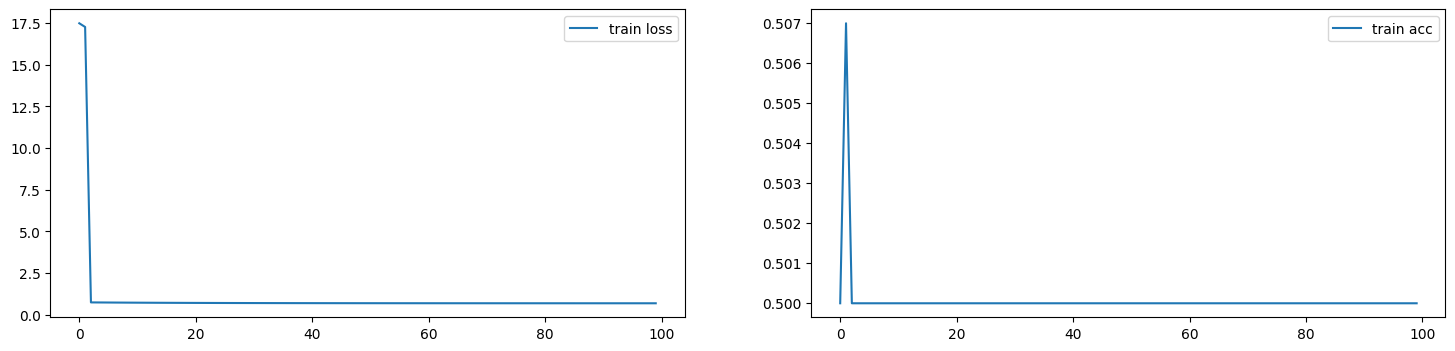

In [46]:
#l'activation ReLu demande une normalisation car comme ça j'ai des valeurs en overflow
#comme dans un cas educatif, je préfère d'abord maitriser les concepts de base.
#Je ne vais pas encore pousser les concets aussi loin
hidden_layers=[64, 32, 16]
activation_types = ["relu"] * (len(hidden_layers)) + ["sigmoid"]
params = neural_network(X_train_flatten, y_train, hidden_layers, 
                          learning_rate=0.01, n_iter=1000, activation_types=activation_types)

100%|██████████| 2000/2000 [00:48<00:00, 41.55it/s]


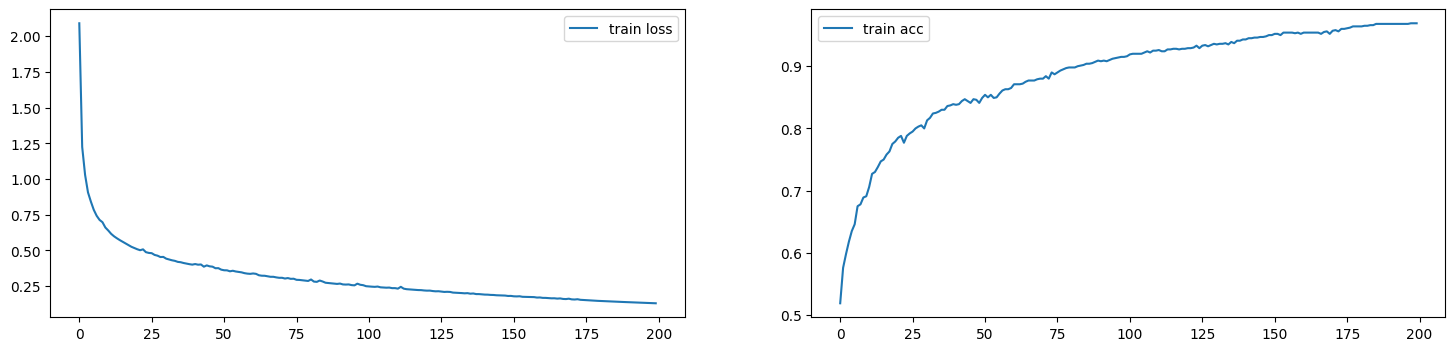

In [64]:
#CONFIG A : tanh + sigmoid et couches décroissantes
#j'obtiens de super résultat avec cette configiration de couche/ neurones combinés à l'activation tanh
#meilleur resultat jusqu'ici : >0.9 et loss < 0.25
#(learning_rate: 0.05, n_iter: 2000, couches : config décroissantes )
hidden_layers=[64, 32, 16]
activation_types = ["tanh"] * (len(hidden_layers)) + ["sigmoid"]
params = neural_network(X_train_flatten, y_train, hidden_layers, 
                          learning_rate=0.05, n_iter=2000, activation_types=activation_types)

100%|██████████| 2000/2000 [00:42<00:00, 46.55it/s]


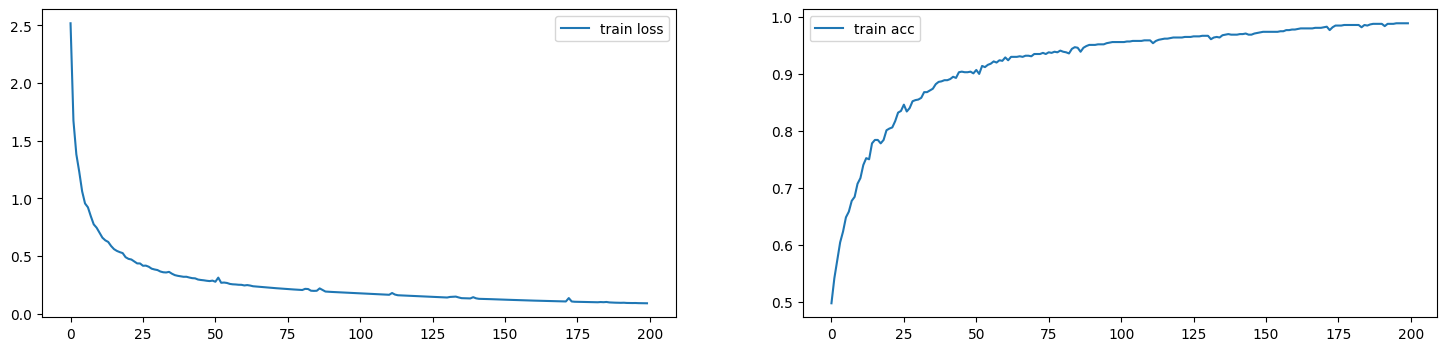

In [75]:
#CONFIG B : tanh + sigmoid et couches à tailles égales
#essai d'autre configuation : 
#couches à taille égale
hidden_layers=[48, 48, 48]
activation_types = ["tanh"] * (len(hidden_layers)) + ["sigmoid"]
params = neural_network(X_train_flatten, y_train, hidden_layers, 
                          learning_rate=0.05, n_iter=2000, activation_types=activation_types)

100%|██████████| 3500/3500 [01:43<00:00, 33.68it/s]


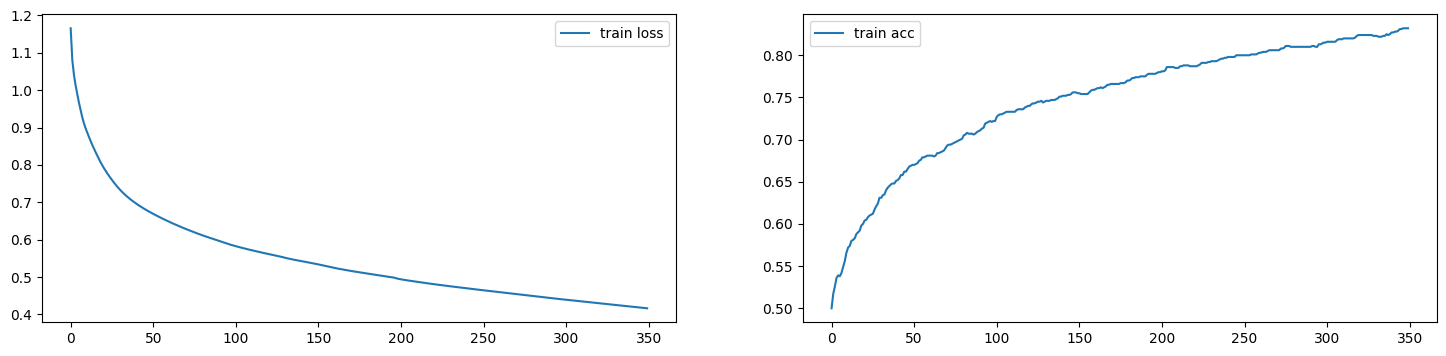

In [73]:
#essai d'autre configuation : 
#config  plus profond
#je remarque avec le meme learning rate (0.05), les courbes sont moins lisses
#mais les résultats sont meilleurs, accuracy score plus proche de 1 et loss bien inférieur à 0.2

#en réduisant le learning rate (0.005), les courbes sont plus stables mais les résultats sot moins bon (loss=0.5, acc' score=0.75)
#nécéssite peut etre un entrainement plus long... eh oui, avec 1500 itérations en plus : (loss proche de 0.4, acc' score > 0.8)
hidden_layers=[64, 48, 32, 16]
activation_types = ["tanh"] * (len(hidden_layers)) + ["sigmoid"]
params = neural_network(X_train_flatten, y_train, hidden_layers, 
                          learning_rate=0.005, n_iter=3500, activation_types=activation_types)

100%|██████████| 500/500 [00:09<00:00, 52.62it/s]


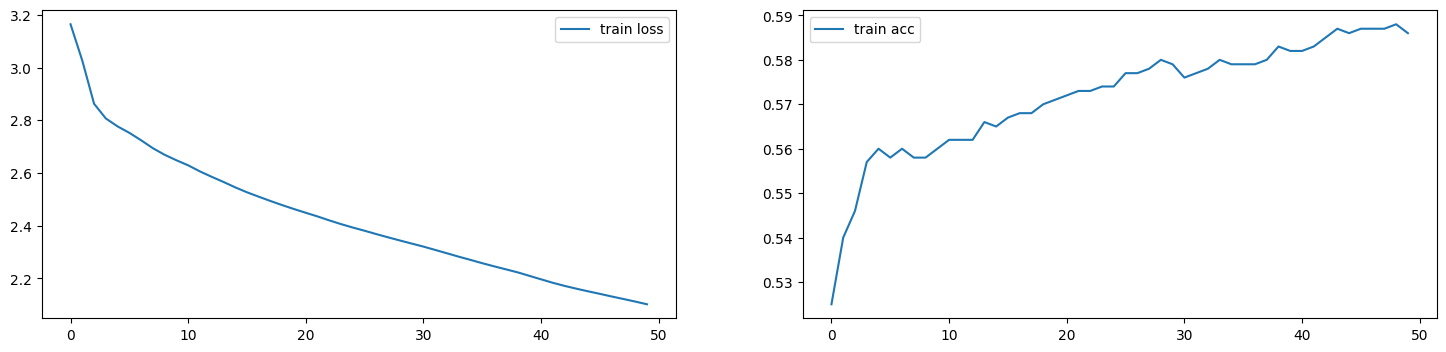

In [58]:
#propoosition de Claude Ai pour experimenter.. 
# mais en cas concret pas ouf de combiner toutes ces activations de ce que j'ai compris
# en tout cas je constate que la loss n'a pas une forme aussi logarithmique qu'avec tanh et ne descend pas autant
#aussi, la train accuracy est plus instable et le score est inférieur. 
#intéressant à voir 
hidden_layers=[64, 32, 16]
activation_types = ["relu", "tanh", "leaky_relu", "sigmoid"]
params = neural_network(X_train_flatten, y_train, hidden_layers, 
                          learning_rate=0.001, n_iter=500, activation_types=activation_types)

# Conclusion
après avoir assimilé les différentes notions aux niveaux d'un neurone, d'aprentissages, loss.. j'ai pu essayé d'experimenter différentes configurations (couches, activations, learning rate), j'ai décourverts d'autres activations, et aussi d'autres configs de couches/neurones qui peuvent être utiliser (dans mon use case ou non). 
A faire un choix sur ce que j'ai pu testé je choisirai la configuaration CONFIG A ou B, au vu des résultats et du temps d'entrainements que j'ai obtenu. Il faudrait que jessaie de jouer un plus avec les params pour mieux comprendre les mécanismes. La config B, comparé à la config A, a un temps d'apprentissages légèrement plus léger (à mon échelle), a l'air d'avoir un accuracy score un peu supérieur à la config 1 mais un loss suéprieur à la loss de la config A.
Bien sur il faudrait que j'experimente avec une activation ReLu qui pourrait offrir de meilleurs performances avec réseau mutlicouches

oups j'ai oublié d'essayer avc le datasets de test!